In [1]:
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv('age_gender.csv')
df.head(10)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
5,1,2,0,20161220144957407.jpg.chip.jpg,195 198 200 200 198 198 199 199 198 197 197 19...
6,1,2,0,20161220145040127.jpg.chip.jpg,208 216 217 219 222 223 222 221 220 220 221 22...
7,1,2,0,20170109191125532.jpg.chip.jpg,99 142 169 177 179 181 183 186 187 186 191 190...
8,1,2,0,20161219222749039.jpg.chip.jpg,127 127 133 140 143 148 152 157 160 165 172 17...
9,1,2,0,20170109191209991.jpg.chip.jpg,199 211 211 214 216 216 219 221 222 224 219 21...


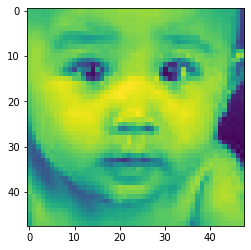

In [4]:
X = df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

x = X[0].reshape((48,48,1))
plt.imshow(x)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.images = dataframe['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
        self.labels = dataframe['gender'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        img = self.images[index].reshape((1,48,48))
        img = img / 255.
        label = self.labels[index]

        if self.transforms:
            img = self.transforms(img)

        return img, label


In [6]:
class ToTensor(object):
    def __call__(self, img):
        img = torch.from_numpy(img)
        return img

transform = transforms.Compose([ToTensor()])

In [7]:
dataset = CustomDataset(df, transforms=transform)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [8]:
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=64)

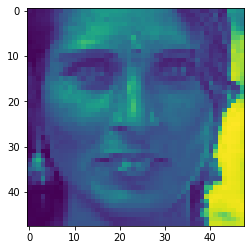

tensor(1)


In [9]:
import random

i = random.randint(1, 64)
for image, label in val_loader:
    plt.imshow(np.transpose(image[i], (1, 2, 0)))
    plt.show()
    print(label[i])
    break

In [10]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(12*12*32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)

        return out

In [11]:
model = ConvNet(2).to(device)
print(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print('Trainable params = ', trainable_params)
print('Total params = ', total_params)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4608, out_features=2, bias=True)
)
Trainable params =  22562
Total params =  22562


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
num_epochs = 10

train_loss_values = []
val_loss_values = []
val_acc_values = []

best_acc = 0

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_true = 0
    val_true = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        model.train()
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_loss_values.append(train_loss)

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        model.eval()
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        val_true += torch.sum(labels == pred).cpu() 
        val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_loss_values.append(val_loss)

    val_acc = val_true / len(valset)
    val_acc_values.append(val_acc)

    print('Epoch [{}/{}]: train_loss = {:.4f}, val_loss= {:.4f}, val_acc = {:4f}.'.format(epoch+1, num_epochs, train_loss, val_loss, val_acc))

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best.ckpt')
        best_acc = val_acc
        print('Saved!')

    print('-'*30)

print('Model with best acc saved as "best.ckpt"!')


C:\Users\dangv\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10]: train_loss = 0.4601, val_loss= 0.3969, val_acc = 0.824299.
Saved!
------------------------------
Epoch [2/10]: train_loss = 0.3571, val_loss= 0.3520, val_acc = 0.844337.
Saved!
------------------------------
Epoch [3/10]: train_loss = 0.3208, val_loss= 0.3256, val_acc = 0.860578.
Saved!
------------------------------
Epoch [4/10]: train_loss = 0.2950, val_loss= 0.3041, val_acc = 0.868804.
Saved!
------------------------------
Epoch [5/10]: train_loss = 0.2783, val_loss= 0.2926, val_acc = 0.871968.
Saved!
------------------------------


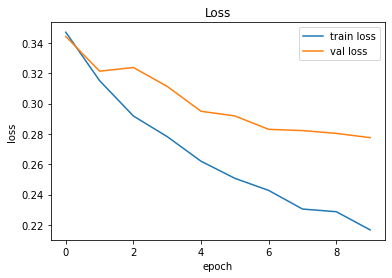

In [ ]:
plt.plot(train_loss_values, label='train loss')
plt.plot(val_loss_values, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()



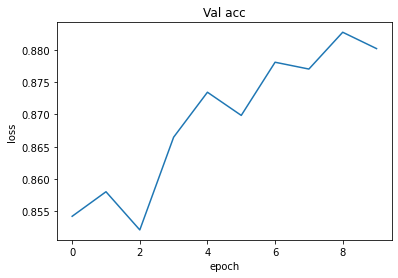

In [ ]:
plt.plot(val_acc_values)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Val acc')
plt.show()

tensor(1)
tensor(1, device='cuda:0')


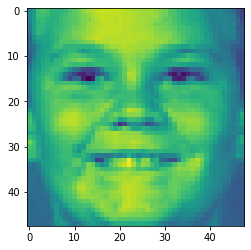

tensor(1)
tensor(0, device='cuda:0')


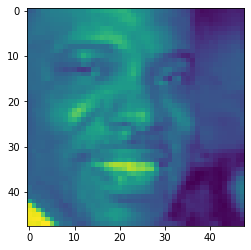

tensor(1)
tensor(1, device='cuda:0')


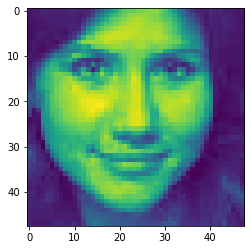

tensor(0)
tensor(0, device='cuda:0')


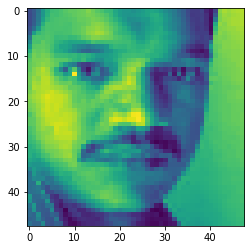

tensor(1)
tensor(1, device='cuda:0')


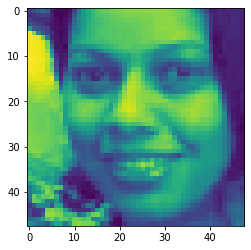

In [ ]:
val_iter = iter(val_loader)

images, labels = next(val_iter)
images = images.to(device)
labels = labels.to(device)

model.load_state_dict(torch.load('best.ckpt'))
model.eval()
outputs = model(images)
_, pred = torch.max(outputs, 1)

for _ in range(5):
    i = random.randint(0, 64)
    print(label[i])
    print(pred[i])
    image = np.transpose(images[i].cpu(), (1, 2, 0))
    plt.imshow(image)
    plt.show()